### Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [1]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환. 
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환. 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [2]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

path = r'/Users/vin_ah/Documents/AI SCHOOL/ML/chapter8/OpinosisDataset1.0/topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=2인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==0].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[-6]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[-6]] , feature_vect[hotel_indexes])
print(similarity_pair)


호텔로 클러스터링 된 문서들의 DataFrame Index: Index([2, 3, 4, 13, 16, 17, 20, 27, 28, 30, 31, 32, 39, 46, 49, 50], dtype='int64')
##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo  와 타 문서 유사도######
[[0.51442299 0.06193118 0.09518068 0.1386783  0.11282857 0.0430688
  0.07049362 0.13989623 0.11742762 0.32619948 1.         0.05221059
  0.05846178 0.38038865 0.06189595 0.03638665]]


In [14]:
document_df[document_df['cluster_label']==0]

,filename,opinion_text,cluster_label
2,room_holiday_inn_london,...,0
3,location_holiday_inn_london,...,0
4,staff_bestwestern_hotel_sfo,...,0
13,service_swissotel_hotel_chicago,...,0
16,service_bestwestern_hotel_sfo,...,0
17,food_holiday_inn_london,...,0
20,staff_swissotel_chicago,...,0
27,service_holiday_inn_london,...,0
28,price_holiday_inn_london,...,0
30,rooms_swissotel_chicago,...,0


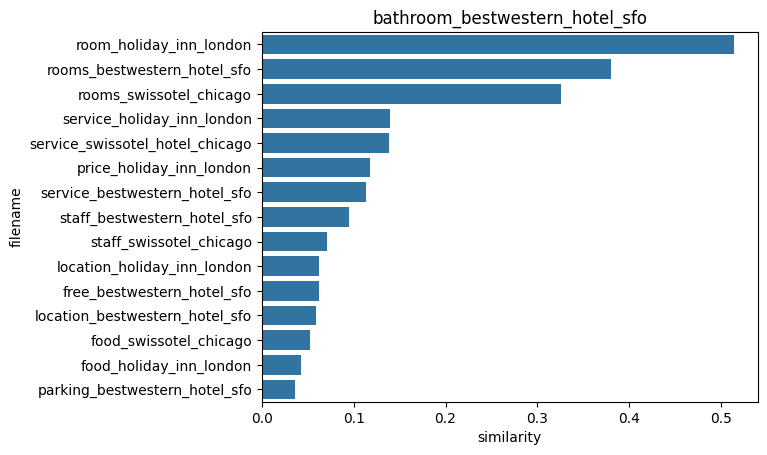

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

fig1 = plt.gcf()
sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)
fig1.savefig('p553_hotel.tif', format='tif', dpi=300, bbox_inches='tight')